# Approximation of Koopman operators in Fock space: Lorenz 63 system

In [1]:
%load_ext nb_mypy
%nb_mypy Off
%matplotlib ipympl

Version 1.0.5


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import nlsa.kernels as knl
import nlsa.function_algebra2 as fun
import nlsa.jax.vector_algebra as vec
import numpy as np
import os
import seaborn as sns
import time
from diffrax import Dopri5, ODETerm, PIDController, SaveAt, diffeqsolve
from functools import partial
from ipywidgets import fixed, interact, IntSlider
from jax import Array, grad, jit, jvp, vmap
from jax.sharding import Mesh, NamedSharding, PartitionSpec
from jaxlib.xla_extension import Device
from math import sqrt
from more_itertools import first, last, take
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from nlsa.abstract_algebra2 import FromScalarField, compose_by, conjugate_by, \
    multiply_by, normalize, smultiply_by
from nlsa.dynamics import orbit, semigroup
from nlsa.function_algebra2 import FunctionSpace, compose, compose2, \
    make_constant
from nlsa.jax.dynamics import flow, from_autonomous, make_l63_vector_field
from nlsa.jax.matrix_algebra import MatrixAlgebra, MatrixSpace
from nlsa.jax.vector_algebra import MeasureFnAlgebra, ScalarField, \
    VectorAlgebra 
from nlsa.jax.utils import make_batched
from nlsa.utils import swap_args
from pathlib import Path
from scipy.sparse.linalg import LinearOperator, svds
from scipy.linalg import eigh
from typing import Callable, Literal, Optional, TypeVar

In [3]:
IDX_CPU: int = 0
IDX_GPU: tuple[int] = (0, 1, 2, 3)
#IDX_GPU: tuple[int] = (1,)
XLA_MEM_FRACTION: Optional[float] = '.97'
FP: Literal['f32', 'f64'] = 'f64'
SORT_BY: Literal['energy', 'frequency'] = 'energy'
FIG_DIR = 'l63'
SAVE_FIGS: bool = True
SAVE_KERNEL_EIGS: bool = True
SAVE_TRAIN_TEST_DATA: bool = True
TRAIN_TEST_DATA_MODE: Literal['calc', 'read'] = 'calc'
KERNEL_EIGS_MODE: Literal['calc', 'read'] = 'calc'
DPI: int = 300
SCL: float = 0.65

if XLA_MEM_FRACTION is not None:
    # This has to come first in order to take effect.
    os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = XLA_MEM_FRACTION

device_cpu = jax.devices("cpu")[IDX_CPU]
devices = [jax.devices('gpu')[i] for i in IDX_GPU]

match FP:
    case 'f64':
        jax.config.update("jax_enable_x64", True)
        r_dtype = jnp.float64
        c_dtype = jnp.complex128
    case 'f32':
        r_dtype = jnp.float32
        c_dtype = jnp.complex64

In [4]:
A = Array  # matrix 
A_ = Array  # sharded matrix
R = Array  # real scalar
Rm = Array  # m-dimensional real vector
X = Array  # state vector
TX = Array # tangent vector
Xs = Array  # collection of state vectors
Xs_ = Array  # sharded collection of state vectors
V = Array  # observable vector  
V_ = Array  # sharded observable vector
Vs = Array  # collection of observable vectors
Vs_ = Array  # sharded collection of observable vectors
K = r_dtype | c_dtype  # type of scalars
Ks = Array  # collection of scalars
S = TypeVar('S')
T = TypeVar('T')
F = Callable[[S], T]  # alias for univariate function

Alpha = Literal['0', '0.5', '1']  # diffusion maps parameters

In [5]:
def make_shard(devices: list[Device]) -> F[A, A_]:
    """Make function to shard array across devices."""
    def shard(a: A) -> A_:
        return jax.device_put_sharded(jnp.split(a, len(devices)), devices)
    return shard


def make_unshard(device: Device) -> F[A_, A]:
    """Make function to concatenate sharded array to a single device."""
    def unshard(a_: A_) -> A:
        return jnp.concatenate(jax.device_put(a_, device))
    return unshard

In [6]:
shard = make_shard(devices)
unshard = make_unshard(device_cpu)
smap = conjugate_by(fun, unshard, fun, shard)
to_cpu = partial(jax.device_put, device=device_cpu)
jvmap = compose(jit, vmap)
jvvmap = compose(jit, compose(vmap, vmap))

## Dynamical system and training/test data

In [7]:
def directional_derivative(v: F[X, TX], f: F[X, R]) -> F[X, R]:
    """Directional derivative with respect to vector field."""
    def g(x: X) -> R:
        _, gx = jvp(f, (x,), (v(x),))
        return gx
    return g

In [8]:
v = make_l63_vector_field()
vgrad = partial(directional_derivative, v) 

In [9]:
N = Literal[80_000]
n: N = 80_000
n_spin = 5000
dt = 3.0

n_tot = n_spin + n
ninv = 1.0 / n
sqrtn = sqrt(n)

match TRAIN_TEST_DATA_MODE:
    case 'calc':
        start_time = time.perf_counter()
        with jax.default_device(device_cpu):
            if FP == 'f32':
                jax.config.update("jax_enable_x64", True)
            x0 = jnp.array([1., 1., 1.])
            ts_tot = jnp.arange(0, n_tot) * dt
            solution = diffeqsolve(terms=ODETerm(jit(from_autonomous(v))),
                                   solver=Dopri5(),
                                   t0=0.0, t1=ts_tot[-1], dt0=dt, y0=x0,
                                   saveat=SaveAt(ts=ts_tot[n_spin-1 : -1]),
                                   stepsize_controller=PIDController(rtol=1e-8,
                                                                     atol=1e-8),
                                   max_steps=200_000_000)
            if FP == 'f32':
                jax.config.update("jax_enable_x64", False)
            xs = jnp.array(solution.ys, dtype=r_dtype)
            ts = jnp.array(solution.ts, dtype=r_dtype) 
        end_time = time.perf_counter()
        print(f'{n_tot} timesteps of length {dt:.3E} '
              f'took {end_time - start_time:.3E} s')
        
        if SAVE_TRAIN_TEST_DATA:
            fnames = [f'dt{dt:.2f}',
                      f'n{n}',
                      'xs']
            fname = '_'.join(fnames) + '.npy'
            pth = Path('data') / FIG_DIR / FP / fname
            pth.parent.mkdir(parents=True, exist_ok=True)
            np.save(pth, xs)
            print("Training data saved.")

    case 'read':
        fnames = [f'dt{dt:.2f}',
                  f'n{n}',
                  'xs']
        fname = '_'.join(fnames) + '.npy'
        pth = Path('data') / FIG_DIR / FP / fname
        xs = np.load(pth)

xs_: Xs_ = shard(xs)

85000 timesteps of length 3.000E+00 took 1.657E+01 s
Training data saved.


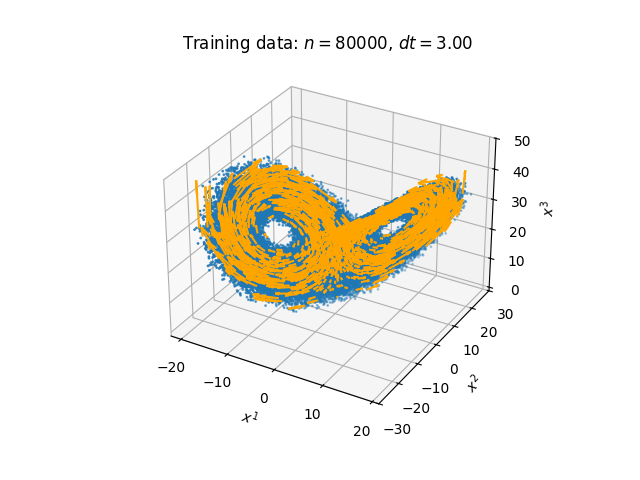

In [10]:
n_skip = 64
i_fig = 1

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_trainingdata(i):
    fig = plt.figure(num=i_fig)
    ax = fig.add_subplot(projection='3d')
    return fig, ax


def plotfig_trainingdata(figspecs):
    fig, ax = figspecs
    xs_plt = xs[::n_skip, :]
    vs_plt = jvmap(v)(xs_plt)
    ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], '.', s=1)
    ax.quiver(xs_plt[:, 0], xs_plt[:, 1], xs_plt[:, 2],
              vs_plt[:, 0], vs_plt[:, 1], vs_plt[:, 2],
              color='orange', length=0.035)
    ax.grid()
    ax.set_title(f'Training data: $n = {n}$, $dt = {dt:.2f}$')
    ax.set_xlabel('$x^1$')
    ax.set_ylabel('$x^2$')
    ax.set_zlabel('$x^3$')
    

plotfig_trainingdata(initfig_trainingdata(i_fig))

In [11]:
dt_tst = 0.01
n_tst = 1000

x0_tst = xs[-1]
ts_tst = jnp.arange(0, n_tst) * dt_tst

match TRAIN_TEST_DATA_MODE:
    case 'calc':
        solution_tst = diffeqsolve(terms=ODETerm(from_autonomous(v)), solver=Dopri5(),
                                   t0=0.0, t1=ts_tst[-1], dt0=dt_tst, y0=x0_tst,
                                   saveat=SaveAt(ts=ts_tst),
                                   stepsize_controller=PIDController(rtol=1e-8,
                                                                     atol=1e-8),
                                   max_steps=200_000_000)
        xs_tst = solution_tst.ys
        ts_tst = solution_tst.ts 
        end_time = time.perf_counter()
        print(f'{n_tst} timesteps of length {dt_tst:.3E} '
              f'took {end_time - start_time:.3E} s')

        if SAVE_TRAIN_TEST_DATA:
            fnames = [f'dt_tst{dt_tst:.2f}',
                      f'n_tst{n}tst',
                      'xs_tst']
            fname = '_'.join(fnames) + '.npy'
            pth = Path('data') / FIG_DIR / FP / fname
            pth.parent.mkdir(parents=True, exist_ok=True)
            np.save(pth, xs_tst)
            print("Test data saved.")

    case 'read':
            fnames = [f'dt_tst{dt_tst:.2f}',
                      f'n_tst{n_tst}',
                      'xs_tst']
            fname = '_'.join(fnames) + '.npy'
            pth = Path('data') / FIG_DIR / FP / fname
            pth.parent.mkdir(parents=True, exist_ok=True)
            xs_tst = np.load(pth)

1000 timesteps of length 1.000E-02 took 2.427E+01 s
Test data saved.


## Basis function computation (NLSA)

In [12]:
scl = ScalarField(dtype=r_dtype)
l2x: MeasureFnAlgebra[X, N, K] = \
    MeasureFnAlgebra(dim=n,
                     dtype=r_dtype,
                     unit=make_constant(shard(jnp.ones(n, dtype=r_dtype))),
                     measure=vec.counting_measure,
                     inclusion_map=vec.jeval_at(xs_, devices=devices))

In [13]:
n_bandwidth: int = 128
log10_bandwidth_lims: tuple[float, float] = (-3.0, 3.0)

start_time = time.perf_counter()
log10_bandwidths = jnp.linspace(log10_bandwidth_lims[0],
                                log10_bandwidth_lims[1], n_bandwidth)
shape_func = partial(knl.make_exponential_rbf, scl)

def k_func(epsilon: R) -> Callable[[X, X], R]:
    return  compose(shape_func(epsilon), vec.sqeuclidean)

k_tune = jit(knl.make_tuning_objective(l2x, k_func, grad))
est_dims = jnp.array([k_tune(epsilon) for epsilon in log10_bandwidths])
i_opt = jnp.argmax(est_dims)
bandwidth_opt = 10.0 ** log10_bandwidths[i_opt]
dim = est_dims[i_opt]
end_time = time.perf_counter()
print(f"Kernel tuning took {end_time - start_time:.3e} s")
print(f"Optimal bandwidth index: {i_opt}")
print(f"Optimal bandwidth: {bandwidth_opt:.3e}")
print(f"Estimated dimension: {dim:.3e}")

Kernel tuning took 7.761e+00 s
Optimal bandwidth index: 64
Optimal bandwidth: 1.056e+00
Estimated dimension: 2.062e+00


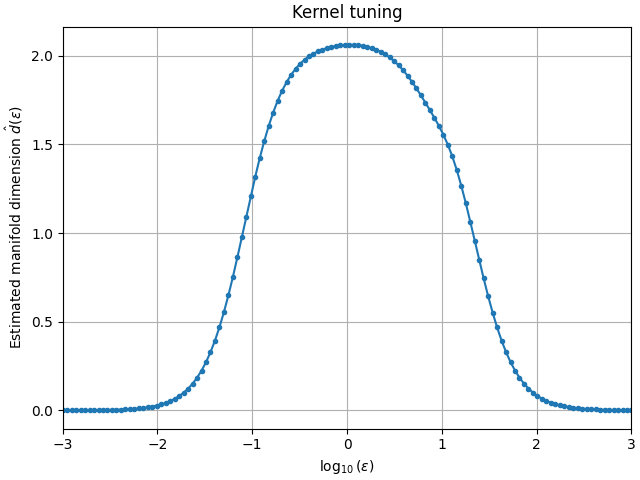

In [14]:
i_fig = 2
if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_tuning(i):
    fig, ax = plt.subplots(num=i, constrained_layout=True)
    return fig, ax


def plotfig_tuning(figspecs):
    fig, ax = figspecs
    ax.plot(log10_bandwidths, est_dims, '.-')
    ax.set_xlim(log10_bandwidth_lims)
    ax.grid()
    ax.set_xlabel(r'$\log_{10}(\epsilon)$')
    ax.set_ylabel(r'Estimated manifold dimension $\hat d(\epsilon)$')
    ax.set_title('Kernel tuning')


plotfig_tuning(initfig_tuning(i_fig))

In [15]:
bandwidth_scl = 2.0  # 1.0

bandwidth = bandwidth_scl * bandwidth_opt
rbf: Callable[[X, X], R] = knl.make_exponential_rbf(scl, bandwidth)
k: Callable[[X, X], R] = compose(rbf, vec.sqeuclidean)
p: Callable[[X, X], R] = knl.dm_normalize(l2x, '1', k)
t_heat = bandwidth**2 / 4.0
fourpi = 4.0 * jnp.pi
vol = knl.riemannian_vol(l2x, p, dim, t_heat, fourpi)
bandwidth_func: F[X, R] = knl.make_bandwidth_function(l2x, k, dim, vol)
scaled_sqeuclidean = knl.make_scaled_sqdist(l2x, vec.sqeuclidean,
                                            bandwidth_func)
print(f"Estimated volume: {vol:.3e}")

Estimated volume: 2.927e+03


In [16]:
i_fig = 3

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_bandwidthfunc(i):
    fig = plt.figure(num=i_fig)
    ax = fig.add_subplot(projection='3d')
    return fig, ax


def plotfig_bandwidthfunc(figspecs):
    fig, ax = figspecs
    plt.rcParams['grid.color'] = "yellow"    
    bw_vals = jvmap(bandwidth_func)(xs)
    sc = ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=bw_vals, s=1, 
                      vmin=jnp.min(bw_vals), vmax=jnp.max(bw_vals),
                      cmap="binary")
    cx = plt.colorbar(sc)
    ax.set_xlabel('$x^1$')
    ax.set_ylabel('$x^2$')
    ax.set_zlabel('$x^3$')
    ax.xaxis.pane.set_facecolor('orange')
    ax.yaxis.pane.set_facecolor('orange')
    ax.zaxis.pane.set_facecolor('orange')
    ax.set_title('Bandwidth function') 
    plt.rcdefaults()


plotfig_bandwidthfunc(initfig_bandwidthfunc(i_fig))

In [17]:
make_shape_func = partial(knl.make_exponential_rbf, scl)


def k_vb_func(epsilon: R) -> Callable[[X, X], R]:
    return compose(make_shape_func(epsilon), scaled_sqeuclidean)


start_time = time.perf_counter()
k_vb_tune = jit(knl.make_tuning_objective(l2x, k_vb_func, grad))
est_vb_dims = jnp.array([k_vb_tune(epsilon)
                         for epsilon in log10_bandwidths])
i_opt_vb = jnp.argmax(est_vb_dims)
vb_bandwidth_opt = 10. ** log10_bandwidths[i_opt_vb]
end_time = time.perf_counter()
print(f"VB kernel tuning took {end_time - start_time:.3e} s")
print(f"Optimal bandwidth index: {i_opt_vb}")
print(f"Optimal bandwidth: {vb_bandwidth_opt:.3e}")
print(f"Estimated dimension: {est_vb_dims[i_opt_vb]:.3e}")

VB kernel tuning took 1.487e+01 s
Optimal bandwidth index: 82
Optimal bandwidth: 7.482e+00
Estimated dimension: 2.022e+00


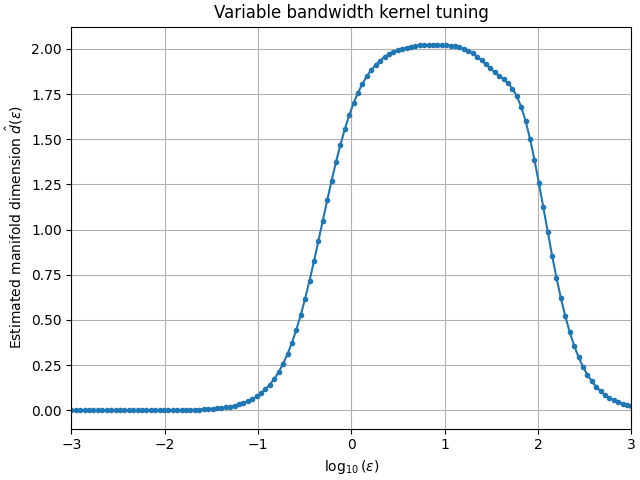

In [18]:
i_fig = 4

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_vbtuning(i):
    fig, ax = plt.subplots(num=i, constrained_layout=True)
    return fig, ax


def plotfig_vbtuning(figspecs):
    fig, ax = figspecs
    ax.plot(log10_bandwidths, est_vb_dims, '.-')
    ax.set_xlim(log10_bandwidth_lims)
    ax.grid()
    ax.set_xlabel(r'$\log_{10}(\epsilon)$')
    ax.set_ylabel(r'Estimated manifold dimension $\hat d(\epsilon)$')
    ax.set_title('Variable bandwidth kernel tuning')


plotfig_vbtuning(initfig_vbtuning(i_fig))

In [19]:
vb_bandwidth_scl = 1.0

vb_bandwidth = vb_bandwidth_scl * vb_bandwidth_opt
rbf_vb: Callable[[X, X], R] = knl.make_exponential_rbf(scl, vb_bandwidth)
k_vb: Callable[[X, X], R] = compose(rbf_vb, scaled_sqeuclidean)
k_bs: Callable[[X, X], R] = knl.bs_normalize(l2x, k_vb)
k_bs_op: Callable[[V], F[X, R]] = knl.make_integral_operator(l2x, k_bs)
g_bs_op: F[V, V] = compose(l2x.incl, k_bs_op)
k_bs_transp = swap_args(k_bs)
k_bs_transp_op = knl.make_integral_operator(l2x, k_bs_transp)
g_bs_transp_op = compose(l2x.incl, k_bs_transp_op)
j_bs_op = jit(g_bs_op)
js_bs_op = jit(vmap(g_bs_op, in_axes=-1, out_axes=-1))
j_bs_transp_op = jit(g_bs_transp_op)
js_bs_transp_op = jit(vmap(g_bs_transp_op, in_axes=-1, out_axes=-1))

In [20]:
eigs_batch_size = 400

make_matmat = compose(partial(make_batched, max_batch_size=eigs_batch_size,
                              in_axis=1),
                      smap)
a_bs = LinearOperator(shape=(n, n), dtype=r_dtype, 
                      matvec=smap(j_bs_op),
                      matmat=make_matmat(js_bs_op),
                      rmatvec=smap(j_bs_transp_op),
                      rmatmat=make_matmat(js_bs_transp_op))

In [21]:
num_eigs: int = 1200

match KERNEL_EIGS_MODE:
    case 'calc':
        start_time = time.perf_counter()
        unsorted_us, unsorted_sigmas, unsorted_vhs = svds(a_bs, num_eigs)
        end_time = time.perf_counter()
        print(f'SVD took {end_time - start_time:.3e} s')

        if SAVE_KERNEL_EIGS:
            fnames = [f'dt{dt:.2f}',
                      f'n{n}',
                      'eigs']
            fname = '_'.join(fnames) + '.npz'
            pth = Path('data') / FIG_DIR / FP / fname
            pth.parent.mkdir(parents=True, exist_ok=True)
            np.savez(pth,
                     unsorted_us=unsorted_us,
                     unsorted_sigmas=unsorted_sigmas,
                     unsorted_vhs=unsorted_vhs)
            print("Kernel eigenvalue/eigenfunction data saved.")

    case 'read':
        fnames = [f'dt{dt:.2f}',
                  f'n{n}',
                  'eigs']
        fname = '_'.join(fnames) + '.npz'
        pth = Path('data') / FIG_DIR / FP / fname
        kernel_eigs = np.load(pth)
        unsorted_us = kernel_eigs['unsorted_us']
        unsorted_sigmas = kernel_eigs['unsorted_sigmas'] 
        unsorted_vhs = kernel_eigs['unsorted_vhs']
        del(kernel_eigs)

SVD took 1.627e+03 s
Kernel eigenvalue/eigenfunction data saved.


In [32]:
num_eigs_l = 1000

cl = VectorAlgebra(dim=num_eigs_l, dtype=c_dtype)
normalize_cl = jit(vmap(partial(normalize, cl), in_axes=1, out_axes=1))
mat_l2x_cl = MatrixSpace(hilb_in=cl, hilb_out=l2x, dtype=r_dtype)
normalize_l2x = jit(vmap(partial(normalize, l2x), in_axes=-1, out_axes=-1))

In [24]:
isort = jnp.argsort(unsorted_sigmas)
sigmas_all = unsorted_sigmas[isort[::-1]]
lambs_all = sigmas_all ** 2
etas_all = (1.0 / lambs_all - 1.0) / (1.0 / lambs_all[1] - 1.0)
us_all = unsorted_us[:, isort[::-1]]
vhs_all = unsorted_vhs[isort[::-1], :]

with jax.default_device(device_cpu):
    sigmas = jnp.array(sigmas_all[1 : (num_eigs_l+1)])
    lambs = jnp.array(lambs_all[1 : (num_eigs_l+1)])
    etas = jnp.array(etas_all[1 : (num_eigs_l+1)])
    phis = us_all[:, 1 : (num_eigs_l+1)] * sqrtn
    gammas = vhs_all[1 : (num_eigs_l+1), :].T * sqrtn

print('First 5 NLSA eigevalues:')
print(lambs[0:5])
print('First 5 Laplacian eigenvalues:')
print(etas[0:5])

First 5 NLSA eigevalues:
[0.99657298 0.99200278 0.98805407 0.9877019  0.9782901 ]
First 5 Laplacian eigenvalues:
[1.         2.34433022 3.51586077 3.62080222 6.45331192]


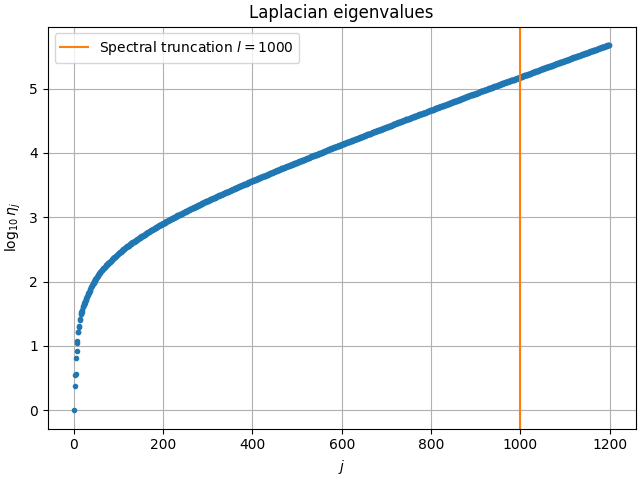

In [25]:
i_fig = 5
n_eig_plt = num_eigs

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_lapleigs(i):
    fig, ax = plt.subplots(num=i, constrained_layout=True)
    return fig, ax


def plotfig_lapleigs(figspecs):
    fig, ax = figspecs
    ax.cla()
    ax.plot(jnp.arange(1, n_eig_plt), jnp.log10(etas_all[1:]), '.')
    ax.axvline(num_eigs_l, color=u'#ff7f0e',
               label=f'Spectral truncation $l = {num_eigs_l}$')
    ax.grid()
    ax.legend()
    ax.set_xlabel('$j$')
    ax.set_ylabel(r'$\log_{10}\eta_j$')
    ax.set_title('Laplacian eigenvalues')


plotfig_lapleigs(initfig_lapleigs(i_fig))

## Spectral decomposition of the generator

In [26]:
to_rkhs = k_bs_op
to_l2x = compose(l2x.incl, to_rkhs)
to_vgrad = compose(vgrad, to_rkhs)
to_vgrad_l2x = compose(l2x.incl, to_vgrad)

interactive(children=(IntSlider(value=3, continuous_update=False, description='j', max=1199), Output()), _dom_…

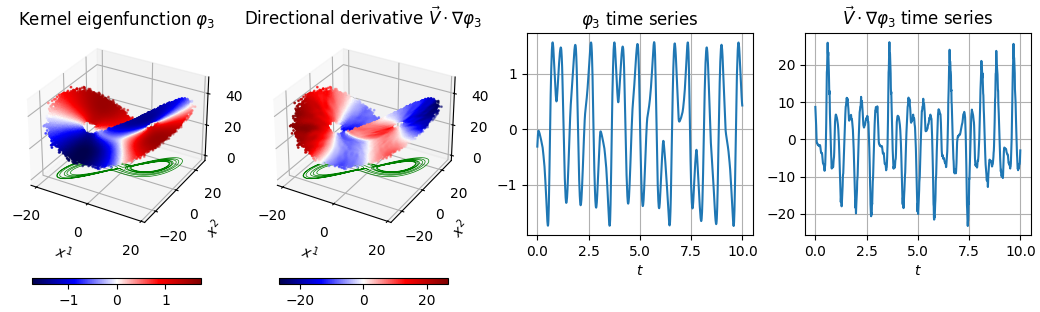

In [28]:
n_plt = n_tst
i_fig = 6

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_kernel_efuncs(i):
    fig = plt.figure(num=i_fig, figsize=(16.0*SCL, 4.8*SCL))
    axs = (fig.add_subplot(1, 4, 1, projection='3d'),
           fig.add_subplot(1, 4, 2, projection='3d'),
           fig.add_subplot(1, 4, 3),
           fig.add_subplot(1, 4, 4))
    fig.set_constrained_layout(True)
    return fig, axs


slider_kernel_efuncs = IntSlider(value=3, min=0, max=n_eig_plt - 1,
                                 continuous_update=False)


@interact(j=slider_kernel_efuncs, figspecs=fixed(initfig_kernel_efuncs(i_fig)),
          save_fig=fixed(SAVE_FIGS))
def plotfigs_kernel_efuncs(j, figspecs, save_fig=False):
    fig, axs = figspecs
    [ax.cla() for ax in axs]

    ts = dt_tst * np.arange(0, n_plt)
    xs_plt = xs_tst[0 : n_plt]
    phi = phis[:, j]
    gamma = shard(gammas[:, j] / sigmas[j])
    vgrad_phi = jit(to_vgrad_l2x)(gamma) 
    varphi = to_rkhs(gamma)
    vgrad_varphi = to_vgrad(gamma)
    phi_ts = jvmap(varphi)(xs_plt)
    vgrad_varphi_ts = jvmap(vgrad_varphi)(xs_plt)

    ax = axs[0]
    a = jnp.max(jnp.abs(phi))
    im = ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=phi, s=1, vmin=-a, vmax=a,
                    cmap="seismic")
    ax.plot(xs_plt[:, 0], xs_plt[:, 1], xs_plt[:, 2] * 0, 'g-', linewidth=0.5)
    try:
        fig.colorbar(im, ax=ax, cax=fig.axes[4], location='bottom',
                     shrink=0.75, aspect=30.0, pad=0.0)
    except:
        fig.colorbar(im, ax=ax, location='bottom', shrink=0.75,
                     aspect=30.0, pad=0.0)
    ax.set_xlabel('$x^1$')
    ax.set_ylabel('$x^2$');
    #ax.set_zlabel('$x^3$');
    ax.set_title(f'Kernel eigenfunction $\\varphi_{{{j}}}$') 

    ax = axs[1]
    a = jnp.max(jnp.abs(vgrad_phi))
    im = ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=vgrad_phi, s=1,
                    vmin=-a, vmax=a, cmap="seismic")
    ax.plot(xs_plt[:, 0], xs_plt[:, 1], xs_plt[:, 2] * 0, 'g-', linewidth=0.5)
    try:
        fig.colorbar(im, ax=ax, cax=fig.axes[5], location='bottom',
                     shrink=0.75, aspect=30.0, pad=0.0)
    except:
        fig.colorbar(im, ax=ax, location='bottom', shrink=0.75,
                     aspect=30.0, pad=0.0)
    ax.set_xlabel('$x^1$')
    ax.set_ylabel('$x^2$')
    #ax.set_zlabel('$x^3$')
    ax.set_title('Directional derivative '
                 f'$\\vec{{V}}\\cdot\\nabla\\varphi_{{{j}}}$')

    ax = axs[2]
    ax.plot(ts, phi_ts)
    ax.set_xlabel('$t$')
    ax.grid()
    ax.set_title(f'$\\varphi_{{{j}}}$ time series') 

    ax = axs[3]
    ax.plot(ts, vgrad_varphi_ts)
    ax.set_xlabel('$t$')
    ax.set_title(f'$\\vec{{V}}\\cdot\\nabla\\varphi_{{{j}}}$ time series')
    ax.grid()

    if save_fig:        
        fnames = [f'dt{dt:.2f}',
                  f'n{n}',
                  f'phi{j}']
        fname = '_'.join(fnames) + '.png'
        pth = Path('figs') / FIG_DIR / FP / fname
        pth.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(pth, bbox_inches='tight', dpi=DPI)

In [33]:
tau = 1.0E-5

with jax.default_device(device_cpu):
    lambs_tau_all = jnp.exp(-0.5 * tau * etas_all)
    lambs_tau = lambs_tau_all[1 : (num_eigs_l+1)]

#rkhs_synth = compose(to_rkhs,
#                     compose(shard,
#                             partial(mat_l2x_cm.app,
#                                     gammas / sigmas * lambs_tau)))
rkhs_synth = compose(to_rkhs,
                     compose(shard,
                             partial(mat_l2x_cl.app, gammas)))

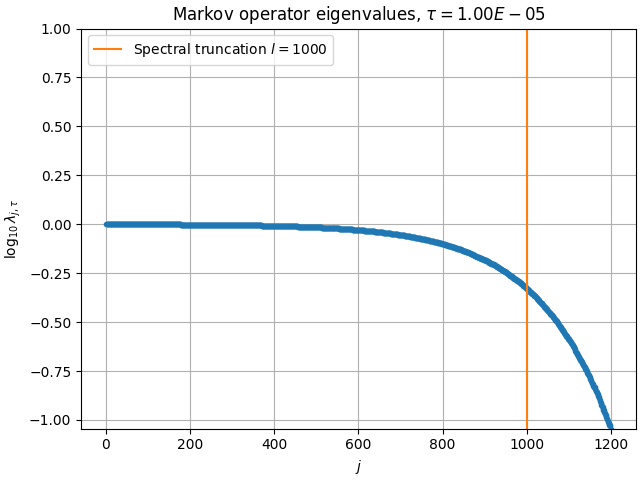

In [34]:
i_fig = 8

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_markoveigs(i):
    fig, ax = plt.subplots(num=i, constrained_layout=True)
    return fig, ax


def plotfig_markoveigs(figspecs):
    fig, ax = figspecs
    ax.cla()
    ax.plot(np.arange(1, n_eig_plt), np.log10(lambs_tau_all[1 : n_eig_plt]),
            '.')
    ax.axvline(num_eigs_l, color=u'#ff7f0e',
               label=f'Spectral truncation $l = {num_eigs_l}$')
    ax.grid()
    ax.legend()
    ax.set_xlabel('$j$')
    ax.set_ylabel(r'$\log_{10}\lambda_{j,\tau}$')
    ax.set_title(f'Markov operator eigenvalues, $\\tau={tau:.2E}$');
    ax.set_ylim((max(-10.0, np.log10(lambs_tau_all[n_eig_plt-1])), 1.0))


plotfig_markoveigs(initfig_lapleigs(i_fig))

In [35]:
phi_batch_size = 100
to_vgrad_l2x_batched = make_batched(smap(jit(vmap(to_vgrad_l2x,
                                                  in_axes=-1, out_axes=-1))),
                                    max_batch_size=phi_batch_size,
                                    in_axis=1)

In [36]:
start_time = time.perf_counter()
vgrad_phis = to_vgrad_l2x_batched(gammas / sigmas)
end_time = time.perf_counter()
print(f'Computation of {num_eigs_l} eigenfunction gradients on training data took '
      f'{end_time - start_time:.3e} s')

Computation of 1000 eigenfunction gradients on training data took 1.392e+02 s


In [37]:
res_z = 0.1

with jax.default_device(device_cpu):
    start_time = time.perf_counter()
    v_mat = phis.T @ vgrad_phis * ninv
    a_mat = 0.5*(v_mat - v_mat.T)/1j
    a_tau_mat = lambs_tau[:, np.newaxis] * a_mat * lambs_tau
    c_mat = res_z * phis - vgrad_phis
    b_mat = c_mat.T @ c_mat * ninv
    end_time = time.perf_counter()
    
print(f'Computation of generalized eigenvalue problem matrices took '
      f'{end_time - start_time:.3e} s')

Computation of generalized eigenvalue problem matrices took 2.588e+00 s


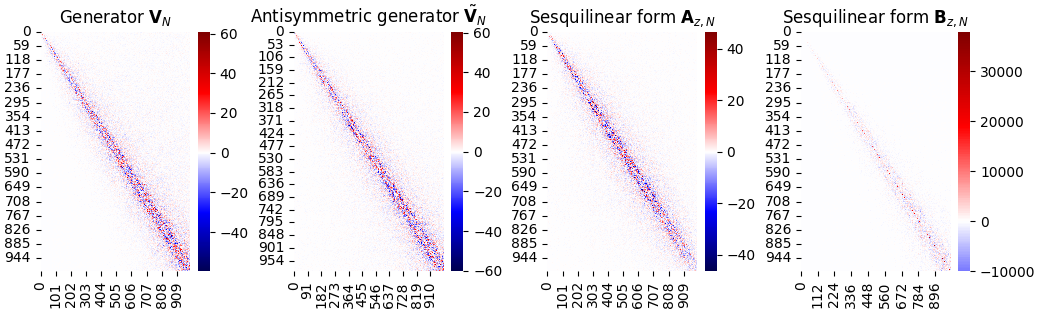

In [39]:
i_fig = 11

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_gev_mats(i):
    fig, axs = plt.subplots(1, 4, num=i_fig, figsize=(16.0*SCL, 4.8*SCL),
                            constrained_layout=True)
    return fig, axs


def plotfig_gev_mats(figspecs, save_fig=False):
    fig, axs = figspecs
    axv, axa, axt, axm = axs
    [ax.cla() for ax in axs] 
    sns.heatmap(v_mat, ax=axv, cmap='seismic', center=0.0, robust=False)
    axv.set_title(r"Generator $\mathbf{V}_N$")
    sns.heatmap(a_mat.imag, ax=axa, cmap='seismic', center=0.0, robust=False)
    axa.set_title(r"Antisymmetric generator $\mathbf{\tilde{V}}_N$")
    sns.heatmap(a_tau_mat.imag, ax=axt, cmap='seismic', center=0.0, robust=False)
    axt.set_title(r"Sesquilinear form $\mathbf{A}_{z,N}$")
    sns.heatmap(b_mat, ax=axm, cmap='seismic', center=0.0, robust=False)
    axm.set_title(r"Sesquilinear form $\mathbf{B}_{z,N}$")

    if save_fig:        
        fnames = [f'dt{dt:.2f}',
                  f'n{n}',
                  f'l{num_eigs_l}',
                  f'z{res_z:.2f}',
                  f'tau{tau:.2e}',
                  'gev']
        fname = '_'.join(fnames) + '.png'
        pth = Path('figs') / FIG_DIR / FP / fname
        pth.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(pth, bbox_inches='tight', dpi=DPI)
        
plotfig_gev_mats(initfig_gev_mats(i_fig), SAVE_FIGS)

In [40]:
start_time = time.perf_counter()
unsorted_gevals, unsorted_gevecs = eigh(a_tau_mat, b_mat)
end_time = time.perf_counter()
print(f'Generalized eigenvalue problem took {end_time - start_time:.3e} s')

Generalized eigenvalue problem took 6.189e-01 s


In [41]:
with jax.default_device(device_cpu):
    unsorted_gevecs = normalize_cl(unsorted_gevecs)
    unsorted_engys = jnp.sum(jnp.abs(unsorted_gevecs)**2 \
                             / lambs[:num_eigs_l, jnp.newaxis],
                             axis=0) - 1.0

    match SORT_BY:
        case 'frequency':
            isort_gen = jnp.argsort(jnp.abs(unsorted_gevals.real))[::-1]
        case 'energy':
            isort_gen = jnp.argsort(unsorted_engys)
    
    gevals = jnp.array(unsorted_gevals[isort_gen])
    res_evals = gevals.real
    eigenfreqs = (1.0 + jnp.sqrt(1.0 - 4.0 * res_z**2 * res_evals**2)) \
        / (2.0 * res_evals)
    engys = unsorted_engys[isort_gen]
    gevecs = normalize_cl(unsorted_gevecs[:, isort_gen])

    
n_print = 70 # 201

with jnp.printoptions(precision=3, suppress=True):
    print('Eigenfrequencies and Dirichlet energies:')
    print(jnp.hstack((jnp.arange(n_print)[:, jnp.newaxis],
                      eigenfreqs[:n_print, jnp.newaxis],
                      engys[:n_print, jnp.newaxis])))

Eigenfrequencies and Dirichlet energies:
[[  0.      2.266   0.416]
 [  1.     -2.266   0.416]
 [  2.      2.365   0.754]
 [  3.     -2.365   0.754]
 [  4.      3.522   1.544]
 [  5.     -3.522   1.544]
 [  6.     -9.929   2.085]
 [  7.      9.929   2.085]
 [  8.      3.825   2.829]
 [  9.     -3.825   2.829]
 [ 10.      7.697   3.183]
 [ 11.     -7.697   3.183]
 [ 12.     -7.487   3.78 ]
 [ 13.      7.487   3.78 ]
 [ 14.     -5.965   3.899]
 [ 15.      5.965   3.899]
 [ 16.     -4.949   4.039]
 [ 17.      4.949   4.039]
 [ 18.      9.858   4.138]
 [ 19.     -9.858   4.138]
 [ 20.      5.891   4.139]
 [ 21.     -5.891   4.139]
 [ 22.     12.353   4.241]
 [ 23.    -12.353   4.241]
 [ 24.      8.734   5.386]
 [ 25.     -8.734   5.386]
 [ 26.    -12.513   5.454]
 [ 27.     12.513   5.454]
 [ 28.      5.547   6.175]
 [ 29.     -5.547   6.175]
 [ 30.      8.461   6.35 ]
 [ 31.     -8.461   6.35 ]
 [ 32.    -10.578   6.77 ]
 [ 33.     10.578   6.77 ]
 [ 34.    -19.862   7.243]
 [ 35.     19.

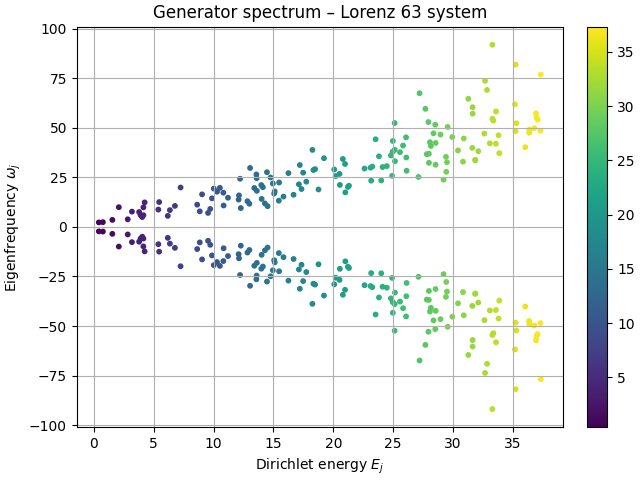

In [43]:
n_gen_eig_plt = 300
i_fig = 12

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

    
def initfig_generator_spec(i):
    fig, ax = plt.subplots(num=i, constrained_layout=True, figsize=(6.4*1.0, 4.8*1.0))
    return fig, ax


def plotfig_generator_spec(figspecs, save_fig=False):
    fig, ax = figspecs
    im = ax.scatter(engys[:n_gen_eig_plt], eigenfreqs[:n_gen_eig_plt], s=10,
                    c=engys[:n_gen_eig_plt])
    fig.colorbar(im, ax=ax)
    ax.grid(True)
    ax.set_xlabel("Dirichlet energy $E_j$")
    ax.set_ylabel(r"Eigenfrequency $\omega_j$")
    ax.set_title("Generator spectrum \u2013 Lorenz 63 system") 

    if save_fig:        
        fnames = [f'dt{dt:.2f}',
                  f'n{n}',
                  f'm{num_eigs_l}',
                  f'z{res_z:.2f}',
                  f'tau{tau:.2e}',
                  'spec']
        fname = '_'.join(fnames) + '.png'
        pth = Path('figs') / FIG_DIR / FP / fname
        pth.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(pth, bbox_inches='tight', dpi=DPI)

plotfig_generator_spec(initfig_generator_spec(i_fig), SAVE_FIGS)

In [44]:
num_zetas = n_print

with jax.default_device(device_cpu):
    start_time = time.perf_counter()
    zetas_l2 = normalize_l2x(c_mat @ gevecs[:, :num_zetas]) * sqrtn
    zetas_coeffs = phis.T @ zetas_l2 * ninv
    zetas_l2 = phis  @ zetas_coeffs
    #zetas_rkhs = (phis * lambs_tau) @ zetas_coeffs
    zetas_rkhs = (phis * sigmas) @ zetas_coeffs
    end_time = time.perf_counter()
    
print(f'Computation of {num_zetas} generator eigenvectors on training data took '
      f'{end_time - start_time:.3e} s')

Computation of 70 generator eigenvectors on training data took 4.185e+00 s


interactive(children=(IntSlider(value=30, continuous_update=False, description='j', max=69), Output()), _dom_c…

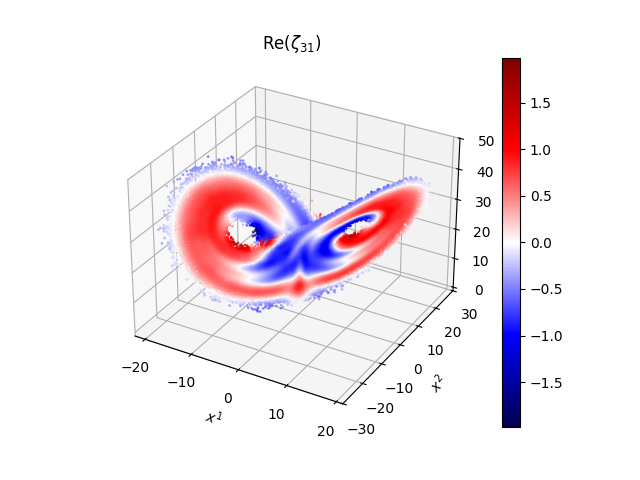

In [48]:
i_fig = 13

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_zetal2(i):
    fig = plt.figure(num=i_fig)
    ax = fig.add_subplot(projection='3d')
    return fig, ax


slider_zetal2 = IntSlider(value=30, min=0, max=num_zetas-1, continuous_update=False)

@interact(j=slider_zetal2, figspecs=fixed(initfig_zetal2(i_fig))) 
def plotfig_zetal2(j, figspecs):
    fig, ax = figspecs
    fxs = zetas_rkhs[:, j].real
    a = jnp.max(jnp.abs(fxs))
    ax.cla()
    sc = ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=fxs, s=1, 
                    vmin=-a, vmax=a, cmap="seismic")
    cx = plt.colorbar(sc)
    ax.set_xlabel('$x^1$')
    ax.set_ylabel('$x^2$')
    ax.set_zlabel('$x^3$')
    ax.set_title(f'$\\mathrm{{Re}}(\\zeta_{{{j + 1}}})$')

interactive(children=(IntSlider(value=30, continuous_update=False, description='j', max=1200), Output()), _dom…

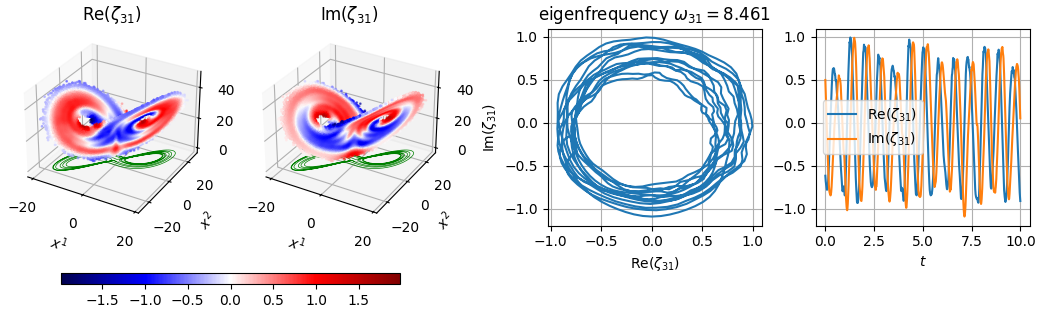

In [50]:
n_plt = n_tst
i_fig = 7

if plt.fignum_exists(i_fig):
    plt.close(i_fig)


def initfig_generator_eigs_ts(i):
    fig = plt.figure(num=i_fig, figsize=(16.0*0.65, 4.8*0.65))
    axs = (fig.add_subplot(1, 4, 1, projection='3d'),
           fig.add_subplot(1, 4, 2, projection='3d'),
           fig.add_subplot(1, 4, 3),
           fig.add_subplot(1, 4, 4))
    fig.set_constrained_layout(True)
    return fig, axs


slider_generator_eigs_ts = IntSlider(value=30, min=0, max=n_eig_plt,
                                     continuous_update=False)


@interact(j=slider_generator_eigs_ts,
          figspecs=fixed(initfig_generator_eigs_ts(i_fig)),
          save_fig=fixed(SAVE_FIGS)) 
def plotfig_generator_eigs(j, figspecs, save_fig=False):
    fig, axs= figspecs
    ts_plt = dt_tst * jnp.arange(0, n_plt)
    xs_plt = xs_tst[0 : n_plt]
    zeta_l2 = zetas_rkhs[:, j]
    zeta_plt = jvmap(rkhs_synth(zetas_coeffs[:, j]))(xs_plt)
    a = max(jnp.max(jnp.abs(zeta_l2.real)), jnp.max(jnp.abs(zeta_l2.imag)))
    
    [ax.cla() for ax in axs]

    sc_re = axs[0].scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=zeta_l2.real, s=1,
                           vmin=-a, vmax=a, cmap="seismic")
    axs[0].plot(xs_plt[:, 0], xs_plt[:, 1], xs_plt[:, 2] * 0, 'g-',
                linewidth=0.5)
    axs[0].set_xlabel('$x^1$')
    axs[0].set_ylabel('$x^2$')
    #axs[0].set_zlabel('$x^3$')
    axs[0].set_title(f'$\\mathrm{{Re}}(\\zeta_{{{j + 1}}})$')

    sc_im = axs[1].scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=zeta_l2.imag, s=1,
                           vmin=-a, vmax=a, cmap="seismic")
    axs[1].plot(xs_plt[:, 0], xs_plt[:, 1], xs_plt[:, 2] * 0, 'g-',
                linewidth=0.5)
    axs[1].set_xlabel('$x^1$')
    axs[1].set_ylabel('$x^2$')
    #axs[1].set_zlabel('$x^3$')
    axs[1].set_title(f'$\\mathrm{{Im}}(\\zeta_{{{j + 1}}})$')

    try:
        fig.colorbar(sc_re, ax=axs[:2], cax=fig.axes[4], 
                     location='bottom', shrink=0.75, aspect=30.0, pad=0.0)
    except:
        fig.colorbar(sc_re, ax=axs[:2], location='bottom', shrink=0.75,
                     aspect=30.0, pad=0.0)
        
    axs[2].plot(zeta_plt.real, zeta_plt.imag, '-')
    axs[2].set_xlabel(f'$\\mathrm{{Re}}(\\zeta_{{{j + 1}}})$')
    axs[2].set_ylabel(f'$\\mathrm{{Im}}(\\zeta_{{{j + 1}}})$')
    axs[2].set_title(f'eigenfrequency $\\omega_{{{j + 1}}}={eigenfreqs[j]:.3f}$')
    axs[2].grid()

    axs[3].plot(ts_plt, zeta_plt.real,
                label=f'$\\mathrm{{Re}}(\\zeta_{{{j + 1}}})$')
    axs[3].plot(ts_plt, zeta_plt.imag,
                label=f'$\\mathrm{{Im}}(\\zeta_{{{j + 1}}})$')
    axs[3].set_xlabel('$t$')
    axs[3].grid()
    axs[3].legend()

    if save_fig:        
        fnames = [f'dt{dt:.2f}',
                  f'n{n}',
                  f'l{num_eigs_l}',
                  f'z{res_z:.2f}',
                  f'tau{tau:.2e}',
                  f'zeta{j + 1}']
        fname = '_'.join(fnames) + '.png'
        pth = Path('figs') / FIG_DIR / FP / fname
        pth.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(pth, bbox_inches='tight', dpi=DPI)